# Introduction
This Code is get from here https://www.cosmicpython.com/book/chapter_01_domain_model.html

Not all code will running flowly, everything can be modified for self learning

The source from the link is for learn python architecture and models, if you want to learn you can go to the pages. The pages is containt good explanation and structured for learning. But, this books is not for the user that first time to code or learning python.

**Abstractions and ABCs**

In a traditional OO language like Java or C#, you might use an abstract base class (ABC) or an interface to define an abstraction. In Python you can (and we sometimes do) use ABCs, but you can also happily rely on duck typing.

The abstraction can just mean "the public API of the thing you’re using"—a function name plus some arguments, for example.

**Layering**

Encapsulation and abstraction help us by hiding details and protecting the consistency of our data, but we also need to pay attention to the interactions between our objects and functions. When one function, module, or object uses another, we say that the one depends on the other. These dependencies form a kind of network or graph.

In a big ball of mud, the dependencies are out of control (as you saw in A real-life dependency diagram (source: "Enterprise Dependency: Big Ball of Yarn" by Alex Papadimoulis)). Changing one node of the graph becomes difficult because it has the potential to affect many other parts of the system. Layered architectures are one way of tackling this problem. In a layered architecture, we divide our code into discrete categories or roles, and we introduce rules about which categories of code can call each other.



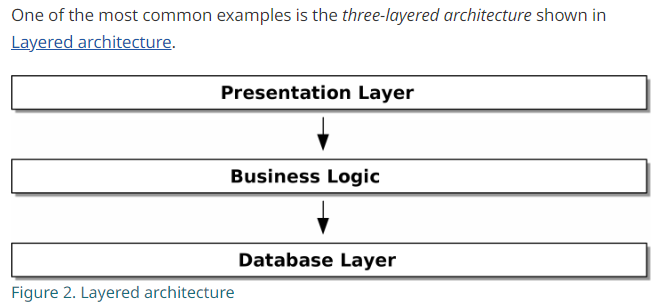

In [ ]:
# This code is error 409
import json
from urllib.request import urlopen
from urllib.parse import urlencode

params = dict(q='Sausages', format='json')
handle = urlopen('http://api.duckduckgo.com' + '?' + urlencode(params))
raw_text = handle.read().decode('utf8')
parsed = json.loads(raw_text)

results = parsed['RelatedTopics']
for r in results:
    if 'Text' in r:
        print(r['FirstURL'] + ' - ' + r['Text'])

In [ ]:
# This code is error 409
import requests

params = dict(q='Sausages', format='json')
parsed = requests.get('http://api.duckduckgo.com/', params=params).json()

results = parsed['RelatedTopics']
for r in results:
    if 'Text' in r:
        print(r['FirstURL'] + ' - ' + r['Text'])

In [ ]:
# This code is error 409
import duckduckpy
for r in duckduckpy.query('Sausages').related_topics:
    print(r.first_url, ' - ', r.text)

# Unit Testing Domain Models

This section is explain for construct a model from the business converstaion

## Some Notes on Allocation
A product is identified by a SKU, pronounced "skew," which is short for stock-keeping unit. Customers place orders. An order is identified by an order reference and comprises multiple order lines, where each line has a SKU and a quantity. For example:

- 10 units of RED-CHAIR

- 1 unit of TASTELESS-LAMP

The purchasing department orders small batches of stock. A batch of stock has a unique ID called a reference, a SKU, and a quantity.

We need to allocate order lines to batches. When we’ve allocated an order line to a batch, we will send stock from that specific batch to the customer’s delivery address. When we allocate x units of stock to a batch, the available quantity is reduced by x. For example:

- We have a batch of 20 SMALL-TABLE, and we allocate an order line for 2 SMALL-TABLE.

- The batch should have 18 SMALL-TABLE remaining.

We can’t allocate to a batch if the available quantity is less than the quantity of the order line. For example:

- We have a batch of 1 BLUE-CUSHION, and an order line for 2 BLUE-CUSHION.

- We should not be able to allocate the line to the batch.

We can’t allocate the same line twice. For example:

- We have a batch of 10 BLUE-VASE, and we allocate an order line for 2 BLUE-VASE.

- If we allocate the order line again to the same batch, the batch should still have an available quantity of 8.

Batches have an ETA if they are currently shipping, or they may be in warehouse stock. We allocate to warehouse stock in preference to shipment batches. We allocate to shipment batches in order of which has the earliest ETA.

In [14]:
from datetime import date
def test_allocating_to_a_batch_reduces_the_available_quantity():
    batch = Batch("batch-001", "SMALL-TABLE", qty=20, eta=date.today())
    line = OrderLine("order-ref", "SMALL-TABLE", 2)
    
    batch.allocate(line)
    
    assert batch.available_quantity == 18

The name of unit test desribe the behavior that we want to see from the system, and the names of the classes and variables that we use are taken from the business jargon.

In [17]:
from dataclasses import dataclass
from typing import Optional, TypeVar

@dataclass(frozen=True)  #(1) (2)
class OrderLine:
    orderid: str
    sku: str
    qty: int


class Batch:
    def __init__(self, ref: str, sku: str, qty: int, eta: Optional[date]):  #(2)
        self.reference = ref
        self.sku = sku
        self.eta = eta
        self.available_quantity = qty

    def allocate(self, line: OrderLine):  #(3)
        self.available_quantity -= line.qty

Our implementation here is trivial: a Batch just wraps an integer available_quantity, and we decrement that value on allocation. We’ve written quite a lot of code just to subtract one number from another, but we think that modeling our domain precisely will pay off.[3]

Let’s write some new failing tests:

In [21]:
def make_batch_and_line(sku, batch_qty, line_qty):
    return (
        Batch("batch-001", sku, batch_qty, eta=date.today()),
        OrderLine("order-123", sku, line_qty),
    )

def test_can_allocate_if_available_greater_than_required():
    large_batch, small_line = make_batch_and_line("ELEGANT-LAMP", 20, 2)
    assert large_batch.can_allocate(small_line)

def test_cannot_allocate_if_available_smaller_than_required():
    small_batch, large_line = make_batch_and_line("ELEGANT-LAMP", 2, 20)
    assert small_batch.can_allocate(large_line) is False

def test_can_allocate_if_available_equal_to_required():
    batch, line = make_batch_and_line("ELEGANT-LAMP", 2, 2)
    assert batch.can_allocate(line)

def test_cannot_allocate_if_skus_do_not_match():
    batch = Batch("batch-001", "UNCOMFORTABLE-CHAIR", 100, eta=None)
    different_sku_line = OrderLine("order-123", "EXPENSIVE-TOASTER", 10)
    assert batch.can_allocate(different_sku_line) is False

There’s nothing too unexpected here. We’ve refactored our test suite so that we don’t keep repeating the same lines of code to create a batch and a line for the same SKU; and we’ve written four simple tests for a new method can_allocate. Again, notice that the names we use mirror the language of our domain experts, and the examples we agreed upon are directly written into code.

We can implement this straightforwardly, too, by writing the can_allocate method of Batch:

In [23]:
def can_allocate(self, line: OrderLine) -> bool:
    return self.sku == line.sku and self.available_quantity >= line.qty

So far, we can manage the implementation by just incrementing and decrementing Batch.available_quantity, but as we get into deallocate() tests, we’ll be forced into a more intelligent solution:

In [24]:
def test_can_only_deallocate_allocated_lines():
    batch, unallocated_line = make_batch_and_line("DECORATIVE-TRINKET", 20, 2)
    batch.deallocate(unallocated_line)
    assert batch.available_quantity == 20

In this test, we’re asserting that deallocating a line from a batch has no effect unless the batch previously allocated the line. For this to work, our Batch needs to understand which lines have been allocated. Let’s look at the implementation:

In [25]:
class Batch:
    def __init__(self, ref: str, sku: str, qty: int, eta: Optional[date]):
        self.reference = ref
        self.sku = sku
        self.eta = eta
        self._purchased_quantity = qty
        self._allocations = set()  # type: Set[OrderLine]

    def allocate(self, line: OrderLine):
        if self.can_allocate(line):
            self._allocations.add(line)

    def deallocate(self, line: OrderLine):
        if line in self._allocations:
            self._allocations.remove(line)

    @property
    def allocated_quantity(self) -> int:
        return sum(line.qty for line in self._allocations)

    @property
    def available_quantity(self) -> int:
        return self._purchased_quantity - self.allocated_quantity

    def can_allocate(self, line: OrderLine) -> bool:
        return self.sku == line.sku and self.available_quantity >= line.qty

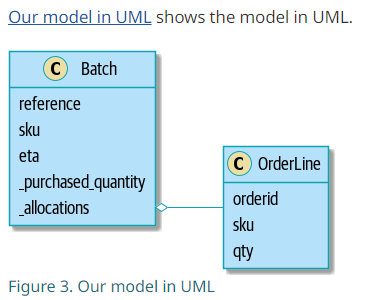

In [26]:
def test_allocation_is_idempotent():
    batch, line = make_batch_and_line("ANGULAR-DESK", 20, 2)
    batch.allocate(line)
    batch.allocate(line)
    assert batch.available_quantity == 18

In [32]:
make_batch_and_line("Stainlesteel Desk", 20, 5)

(<__main__.Batch at 0x21224f6a890>,
 OrderLine(orderid='order-123', sku='Stainlesteel Desk', qty=5))

In [30]:
test_allocating_to_a_batch_reduces_the_available_quantity()
# test_allocation_is_idempotent()

# More types for more type hints

In [ ]:
from dataclasses import dataclass
from typing import NewType

Quantity = NewType("Quantity", int)
Sku = NewType("Sku", str)
Reference = NewType("Reference", str)
...

class Batch:
    def __init__(self, ref: Reference, sku: Sku, qty: Quantity):
        self.sku = sku
        self.reference = ref
        self._purchased_quantity = qty